<a href="https://colab.research.google.com/github/juniorworku/Food-Recognition-System/blob/main/notebooks/Food_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recognition using Keras and TensorFlow

## OverView:
The main aim of this project is to develop a deep learning model to recognize foods form images and tries to estimate their calories content. By using convolutional neural networks for image recognition and regression model for estimation of the calorie content, the model predict based on the image given.

## Objectives:
 - Download and extract the dataset (Food 101)
 - Understand data structure
 - Visualize some random images for the dataset
 - Split the images data into train abd test
 - Create a subset of data with classes(3) train_mini and test_mini for experimenting
 - Fine tune the dataset using pretrained Inception model
 - Visualize the loss and accuracy using plots
 - Predict classes for new set of images

## Step 1: Setup and Loading

### Importing Libraries

In [5]:
import tensorflow as tf
import matplotlib.image as img
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling3D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L2
from tensorflow import keras
from tensorflow.keras import models
import zipfile


### Checking State of GPU

In [6]:
# TensorFlow version
print("TensorFlow version:", tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.17.0
Num GPUs Available:  0


### Download and Extract the Dataset

In [7]:
def get_data():
    if os.path.isdir("food-101"):
      print("Dataset already exists")
    else:
      !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
      print("Dataset downloaded")
      print("Extracting dataset")
      !tar -xzf food-101.tar.gz
      print("Dataset extracted")

In [8]:
get_data()

--2024-10-20 08:24:39--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-10-20 08:24:39--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  85.3MB/s    in 51s     

2024-10-20 08:25:30 (93.9 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded
Extracting dataset
Dataset extracted


## Data Exploration

In [9]:
!ls food-101

images	license_agreement.txt  meta  README.txt


- The dataset contain 101000 images with 101 classes
- Each classes contain 750 training samples and 250 test samples
- All images size has the a maximum side length of 512 pixels

### Understanding the Structure od the image data

In [10]:
os.listdir("food-101/images")

['mussels',
 'creme_brulee',
 'garlic_bread',
 'gyoza',
 'fried_calamari',
 'falafel',
 'cheesecake',
 'chocolate_mousse',
 'pancakes',
 'french_onion_soup',
 'beet_salad',
 'pad_thai',
 'peking_duck',
 'tacos',
 'sushi',
 'spaghetti_bolognese',
 'greek_salad',
 'cup_cakes',
 'bruschetta',
 'eggs_benedict',
 'dumplings',
 'tiramisu',
 'crab_cakes',
 'french_toast',
 'panna_cotta',
 'samosa',
 'hamburger',
 'pho',
 'filet_mignon',
 'chicken_quesadilla',
 'macarons',
 'macaroni_and_cheese',
 'risotto',
 'ramen',
 'oysters',
 'miso_soup',
 'chicken_wings',
 'sashimi',
 'waffles',
 'gnocchi',
 'lasagna',
 'strawberry_shortcake',
 'shrimp_and_grits',
 'beef_carpaccio',
 'deviled_eggs',
 'escargots',
 'tuna_tartare',
 'hot_dog',
 'lobster_roll_sandwich',
 'frozen_yogurt',
 'red_velvet_cake',
 'poutine',
 'club_sandwich',
 'foie_gras',
 'churros',
 'steak',
 'hummus',
 'lobster_bisque',
 'chicken_curry',
 'cheese_plate',
 'grilled_salmon',
 'ceviche',
 'chocolate_cake',
 'croque_madame',
 'do

In [11]:
os.listdir("food-101/meta")

['test.txt',
 'train.txt',
 'test.json',
 'classes.txt',
 'labels.txt',
 'train.json']

In [12]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [13]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [14]:
!head food-101/meta/test.txt

apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017


## Data Visualization

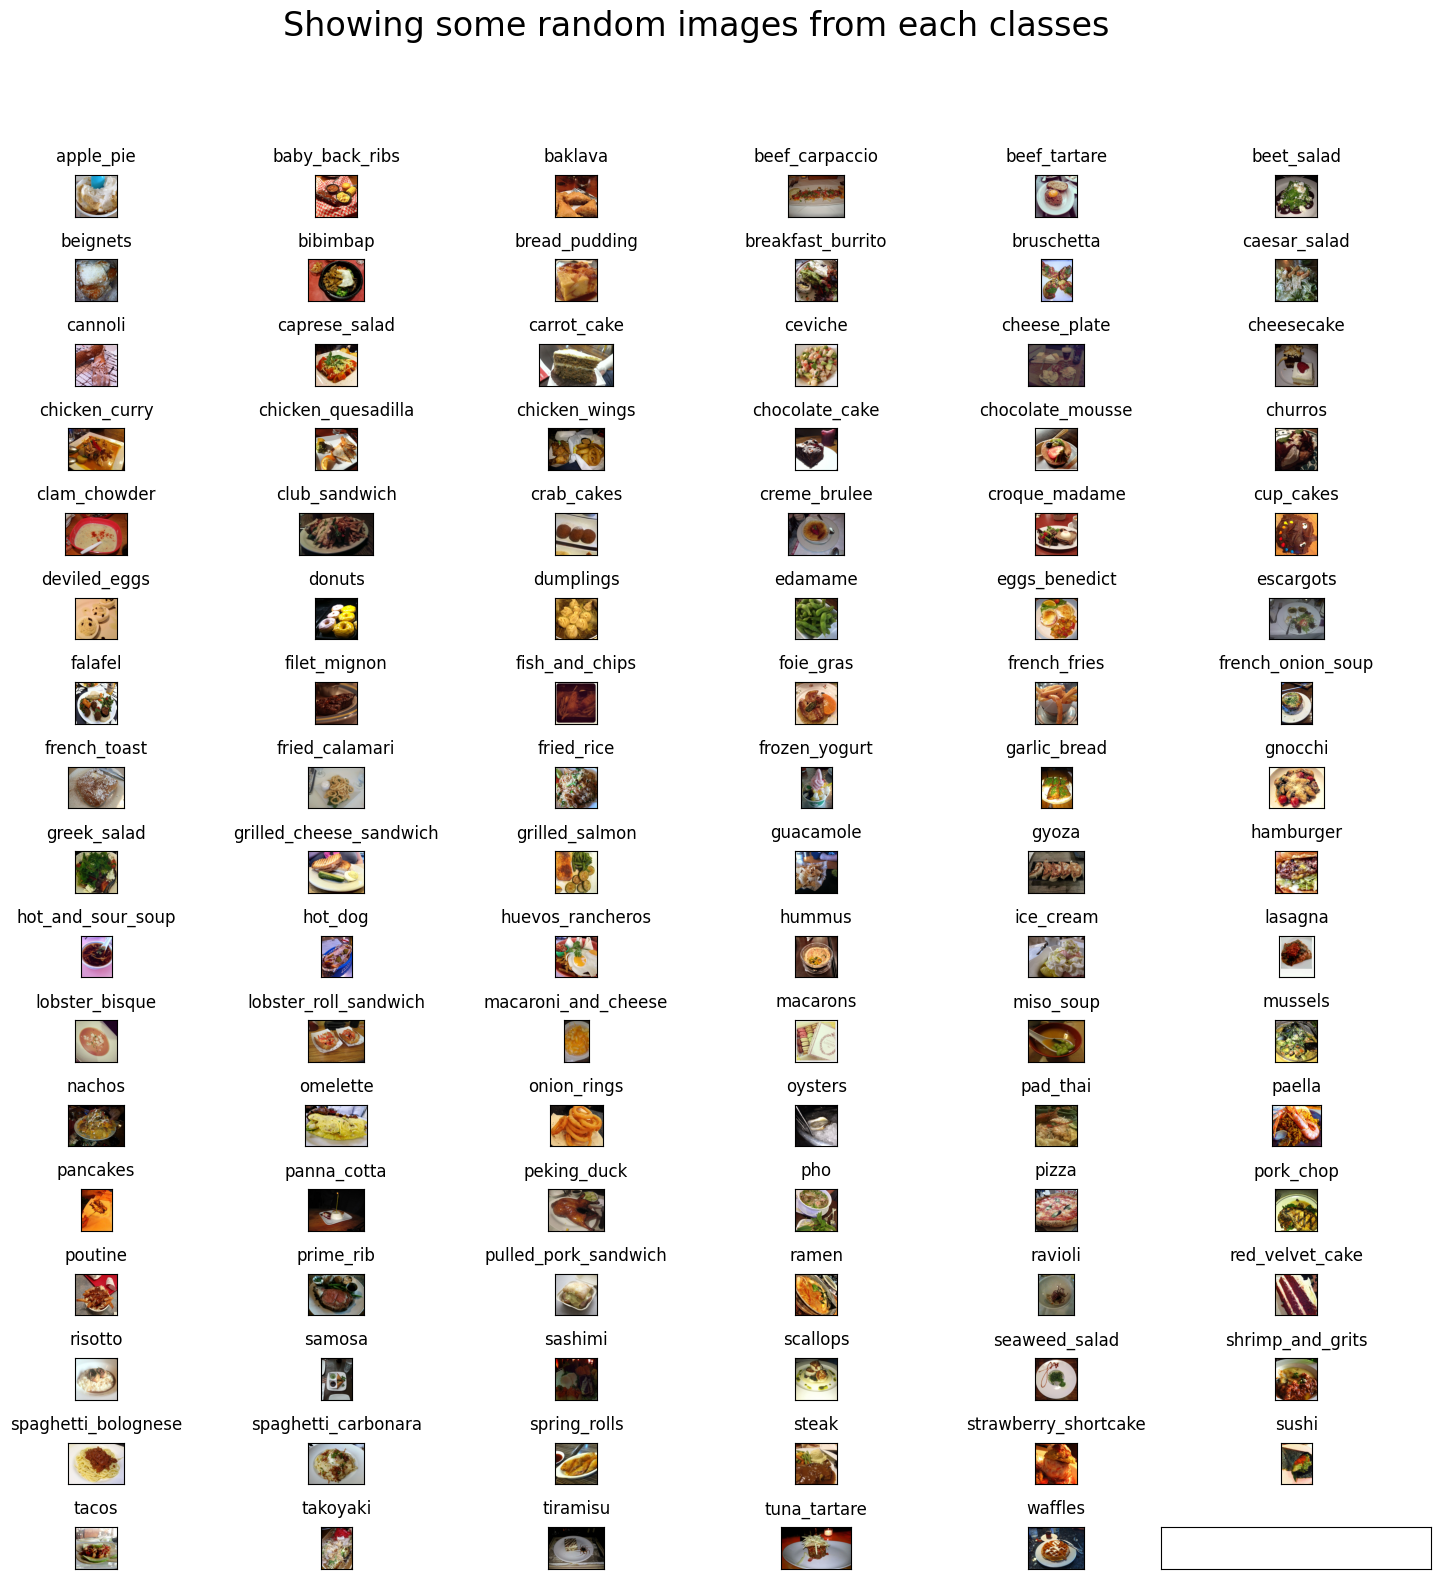

In [15]:
# Define the rows and cols for the subplot
rows = 17
cols = 6

# Create a subplot grid
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

# Set the title for the plot
fig.suptitle("Showing some random images from each classes", y=1.05, fontsize=24)

# Define the Dir for the image data
data_dir = "food-101/images"

# Sort the list of food class names
foods_sorted = sorted(os.listdir(data_dir))

# Diaplaying the images
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == ".DS.Store":
      continue

    # Get the list of all images in this class
    food_selected_images = os.listdir(os.path.join(data_dir, food_selected))

    # Randomly select an image
    food_selected_random = random.choice(food_selected_images)

    # Read the image and Display
    img = plt.imread(os.path.join(data_dir, food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad=10) # setting the title

  # Remove x and y ticks from all subplots
  plt.setp(ax, xticks=[], yticks=[])

plt.tight_layout()
plt.show()


## Data Preprocessing

### Data Splitting

In [16]:
def prepare_data(filepath, src, dest):
  # Creating a dict to store the images path fr the classes
  classes_images = defaultdict(list)

  # Reading the fielpatj to extract the image path
  with open(filepath, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for p in paths:
      food = p.split('/')
      classes_images[food[0]].append(food[1] + '.jpg')


  # Iterate the classes and copy images
  for food in classes_images.keys():
    print("\nCopying images into ", food)
    if not os.path.exists(os.path.join(dest, food)):
      os.makedirs(os.path.join(dest, food))
    for i in classes_images[food]:
      copy(os.path.join(src, food, i), os.path.join(dest, food, i))

  print(f"Copying of images done for {food} class")
  print("Coping Done!")



## Preparing the Train Dataset

In [17]:
# Print message indicating the start of creating train data
print("Creating train data...")

if "food-101/train" in os.listdir():
  print("Train folder already exists")
else:
  # Call prepare_data function to copy images from train.txt to train directory
  prepare_data("food-101/meta/train.txt", "food-101/images", "food-101/train")

  # Print message indicating the end of creating train data
  print("Creating train data done!")

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

### Preparing the Test Dataset

In [18]:
print("Creating test data...")

if "food-101/test" in os.listdir():
  print("Test folder already exists")
else:
  # Call prepare_data function to copy images from test.txt to test directory
  prepare_data("food-101/meta/test.txt", "food-101/images", "food-101/test")

  # Print message indicating the end of creating test data
  print("Creating test data done!")

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [19]:
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [20]:
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


#### Note:
Since we have more than a 100 classes in our dataset, to expriment and to build a model will take a lot of time and computing, so it is neccessory to create a dataset with three classes with tain_mini and test_mini.

In [21]:
# Remove .DS_Store from the list
del foods_sorted[0]

In [22]:
print(foods_sorted)

['baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels'

### Creating a Subset

In [23]:
def dataset_mini(food_list, src, dest):
  # Check if the dest dir exists
  if os.path.exists(dest):
    # If it exists, remove it
    rmtree(dest)
  # Create the dest dir
  os.makedirs(dest)

  # Iterate over the food list
  for food_item in food_list:
    print("Copying images into", food_item)
    # Continously copy the image from the src dir to the dest dir for each food item
    copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

In [24]:
# List of food items for the new creating mini datasets
food_list = ['apple_pie', 'pizza', 'omelette']

# Setting the source and destination directories for the train and test datasets
src_train = "food-101/train"
dest_train = "food-101/train_mini"
src_test = "food-101/test"
dest_test = "food-101/test_mini"

# Creating train_mini datasets
dataset_mini(food_list, src_train, dest_train)

# Creating test_mini datasets
dataset_mini(food_list, src_test, dest_test)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [25]:
print("Creating train data folder with new classes")

# Create train_mini dataset with specified food classes
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [26]:
print("Total number of samples in train folder")
!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [27]:
print("Creating test data folder with new classes")

# Create test_mini dataset with specified food classes
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [28]:
print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


# Training Neural Network Model for Image Classification

- By using a pretrained models like VGG,Inception,ResNet that are already trained on datasets like ImageNet, we can use the already learned weights and add a few layers on top of it to fine tune the model.

In [29]:
# Clear Previous Keras session
K.clear_session()

# Number if classes in the datasets
n_classes = 3

# Image dimensions
img_width, img_height = 299, 299

# Dir for the training and validation data
train_data_dir = "food-101/train_mini"
validation_data_dir = "food-101/test_mini"

# Numbers of samples in the training and validation sets
nb_train_samples = 2250
nb_validation_samples = 750

# Batch size for the training
batch_size = 16

# Data augmentation and normalization (Training images)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Data augmentation and normalization (Validation images)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generate batches of training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Generate batches of validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load the pre-trained InceptionV3 model without the top layer
inception = InceptionV3(weights='imagenet', include_top=False)

# Add custom top layers for fine-tuning
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Predictions layer with a softmax activation for classes
predictions = Dense(3, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Create the final model with InceptionV3 as the base and custom top layers
model = Model(inputs=inception.input, outputs=predictions)

# Compile the model with SDG optimizer, categorical cross-entropy loss, and accuracy metrics
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for saving the best model and logging training history
checkpointer = ModelCheckpoint(filepath='best_model_3class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

# Train the model using the training and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

# Save the model to HDF5 file format
model.save("model_trained_3classes.keras")


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4028 - loss: 1.1162 
Epoch 1: val_loss improved from inf to 0.85473, saving model to best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 2417s 17s/step - accuracy: 0.4033 - loss: 1.1158 - val_accuracy: 0.7364 - val_loss: 0.8547
Epoch 2/15
  1/140 ━━━━━━━━━━━━━━━━━━━━ 35:17 15s/step - accuracy: 0.4375 - loss: 1.0963

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.85473
140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 450ms/step - accuracy: 0.4375 - loss: 1.0963 - val_accuracy: 0.7143 - val_loss: 0.9197
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6587 - loss: 0.8677 
Epoch 3: val_loss improved from 0.85473 to 0.65767, saving model to best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 2347s 17s/step - accuracy: 0.6588 - loss: 0.8675 - val_accuracy: 0.8288 - val_loss: 0.6577
Epoch 4/15
  1/140 ━━━━━━━━━━━━━━━━━━━━ 36:43 16s/step - accuracy: 0.6250 - loss: 0.8525
Epoch 4: val_loss improved from 0.65767 to 0.62957, saving model to best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.6250 - loss: 0.8525 - val_accuracy: 0.9286 - val_loss: 0.6296
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7760 - loss: 0.6864 
Epoch 5: val_loss improved from 0.62957 to 0.51849, saving model to best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 2408s 17s/step - accuracy

### Class indices **Mapping**

In [30]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

## Visualizing the Training and Validation Accuracy

In [31]:
# Plot training and validation accuracy over epochs
def plot_accuracy(history, title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history["val_accuracy"])
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["train_accuracy", "validation_accuracy"], loc="best")
  plt.show()

# Plot training and validation loss over epochs.
def plot_loss(history, title):
  plt.title(title)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["train_loss", "validation_loss"], loc="best")
  plt.show()

## Model Evalution

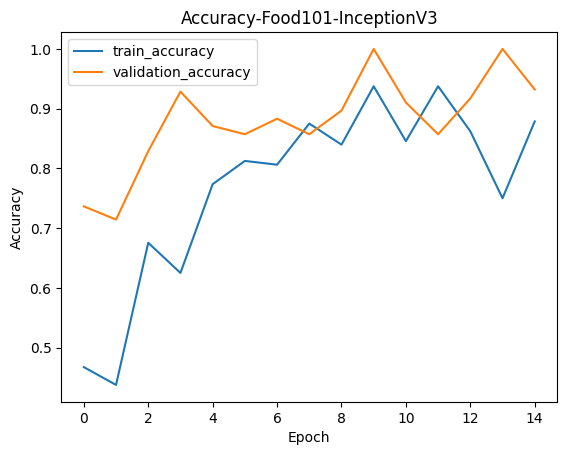

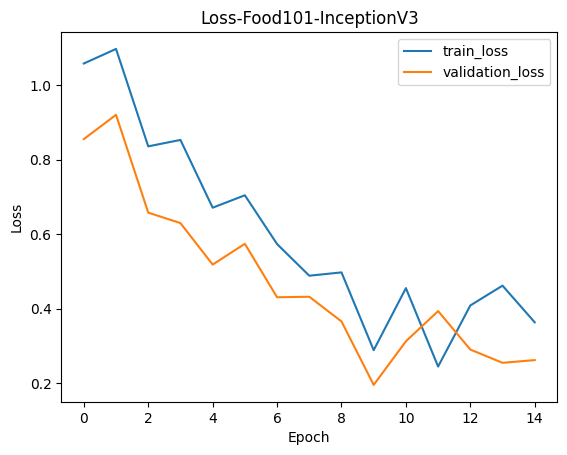

In [32]:
# Plot training and validation accuracy
plot_accuracy(history, "Accuracy-Food101-InceptionV3")

# Plot training and validation loss
plot_loss(history, "Loss-Food101-InceptionV3")

- The plots show that the accuracy of the model increased with epochs and the loss has decreased.
- Validation accuracy has been on the higher side than training accuracy for many epochs This could be for several reasons.

In [33]:
# Loading the best saved model to make predictions
K.clear_session()  # Clear Keras session
model_best = load_model('best_model_3class.keras', compile=False)  # Load the best saved model

## Predicting Class Label

In [34]:
def predict_class(model, images, show = True):
  for img in images:
        img = image.load_img(img, target_size=(299, 299))  # Load image and resize to model's input size
        img = image.img_to_array(img)                     # Convert image to numpy array
        img = np.expand_dims(img, axis=0)                 # Add batch dimension
        img /= 255.                                       # Normalize pixel values

        pred = model.predict(img)                         # Make prediction
        index = np.argmax(pred)                           # Get the index of the class with the highest probability
        food_list.sort()                                  # Sort the list of food items
        pred_value = food_list[index]                     # Get the predicted class label

        if show:
            plt.imshow(img[0])                           # Display the image
            plt.axis('off')
            plt.title(pred_value)                        # Set title as the predicted class label
            plt.show()



## Downloading Images from the Internet

In [37]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
#!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

--2024-10-20 14:05:18--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 172.67.139.59, 104.21.79.5, 2606:4700:3037::ac43:8b3b, ...
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg [following]
--2024-10-20 14:05:18--  https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-10-20 14:05:18 ERROR 404: Not Found.

--2024-10-20 14:05:19--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
C

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


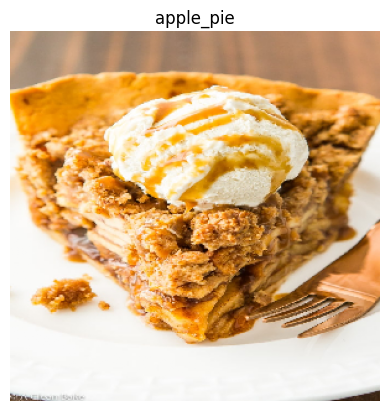

In [39]:
# Make a list of downloaded images
images = ['applepie.jpg']

# Test the trained model
predict_class(model_best, images, True)

In [40]:
model_best.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 22,031,011 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)